## Exploring wrangled data from the Animal Shelter.

* The main goal is to find out what if anything helps increase animal adoptions based on the basic intake data recorded by most animal shelters.

****

In [1]:
#first import the packages needed.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt

#set max rows of pandas to display to 1000
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

#now import the data
dogs_join = pd.read_csv('C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dogs_join.csv', encoding='latin-1')

C:\Users\sethh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
print(dogs_join.head(5))

#we can drop the breed, name_out columns as they are redundant
#dogs_join = dogs_join.drop(['breed','name_out'], axis=1)

  animal_id datetime_in intake_condition      intake_type name_in    color1  \
0   A006100  2014-03-07           Normal    Public Assist   Scamp    Yellow   
1   A006100  2014-12-19           Normal    Public Assist   Scamp    Yellow   
2   A006100  2017-12-07           Normal            Stray   Scamp    Yellow   
3   A047759  2014-04-02           Normal  Owner Surrender    Oreo  Tricolor   
4   A134067  2013-11-16          Injured    Public Assist  Bandit     Brown   

  color2  intake_age found_loc intake_sex intake_fixed             breed1  \
0  White        72.0    Austin       Male     Neutered   Spinone Italiano   
1  White        84.0    Austin       Male     Neutered   Spinone Italiano   
2  White       120.0    Austin       Male     Neutered   Spinone Italiano   
3   None       120.0    Austin       Male     Neutered          Dachshund   
4  White       192.0    Austin       Male     Neutered  Shetland Sheepdog   

  breed2  intake datetime_out outcome_subtype     outcome_type

### 1) Now let's look at the adoptions as a whole
* a) Look at the categories of outtake types.
* b) Look at adoptions over time.
* c) Look at time to adoption distribution for adoption outcomes.
    * Break into categories for time to adoption analysis later on.

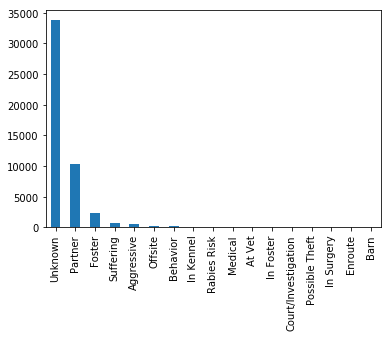

Unknown                33796
Partner                10385
Foster                  2360
Suffering                709
Aggressive               489
Offsite                  257
Behavior                 132
In Kennel                101
Rabies Risk               85
Medical                   63
At Vet                    33
In Foster                 22
Court/Investigation       22
Possible Theft             7
In Surgery                 7
Enroute                    6
Barn                       1
Name: outcome_subtype, dtype: int64


In [3]:
#a. get value_counts of the outcome_type series.
#first look to see if the data in the outcome_subtype series provides that much information.
subtypes = dogs_join.outcome_subtype.value_counts()
subtypes.plot(kind='bar')
plt.show()
print(subtypes)
#The majority of the subtypes are unknown.  So, let's just focus on the type.

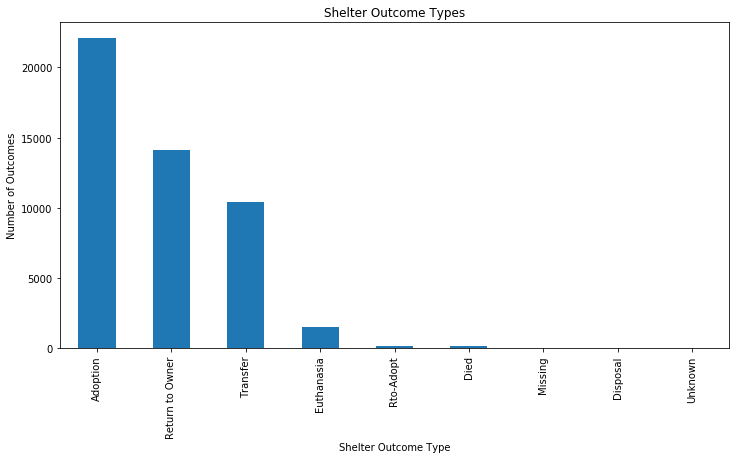

Adoption           22101
Return to Owner    14101
Transfer           10386
Euthanasia          1520
Rto-Adopt            181
Died                 157
Missing               17
Disposal              10
Unknown                2
Name: outcome_type, dtype: int64


In [4]:
#now get a distribution of outcome types
out_types = dogs_join.outcome_type.value_counts()
plt.figure(figsize=(12,6))
out_types.plot(kind='bar')
plt.title('Shelter Outcome Types')
plt.xlabel('Shelter Outcome Type')
plt.ylabel('Number of Outcomes')
plt.show()
print(out_types)

It seems that the most common outcome types are adoptions or return to owner which is good for the dogs as this means they now have a home.  More attention will be paid a little later into the stats behind the adopted vs. animals that leave the shelter in less fortunate means.

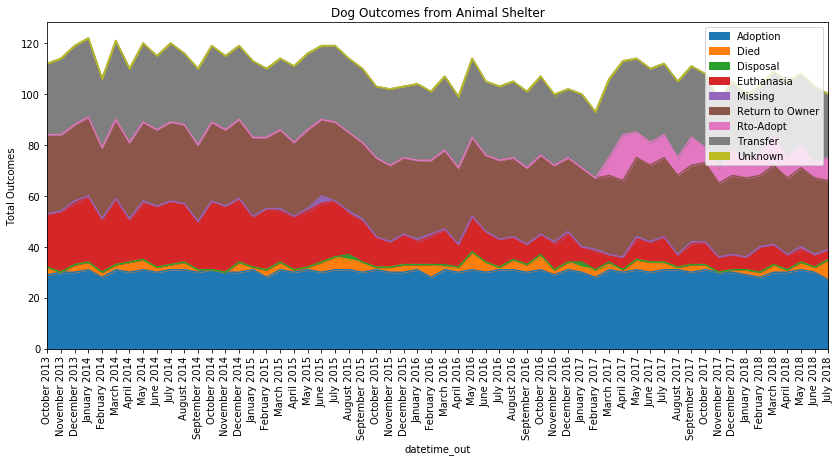

In [5]:
#b. let's look at adoptions over time.  This will be a surface glance, not taking into account multiple adoptions etc.
#organize dogs_join by datetime_out as the index
dogs_join_time = dogs_join.set_index('datetime_out', drop=True)

#sort by index
dogs_join_time = dogs_join_time.sort_index()

#break out each outcome type over time to get a graph stacked by outcome type
dogs_by_type = pd.pivot_table(dogs_join_time, values='intake_condition', columns='outcome_type', aggfunc='count', 
                              index=dogs_join_time.index)
dogs_by_type.index = pd.to_datetime(dogs_by_type.index)

#resample by month then plot a stacked area plot
dogs_by_type = dogs_by_type.resample('M').count()
dogs_by_type.plot(kind='area', stacked=True, figsize=(14,6))

#calculate the x labels and format the plot
x_labels = [date.strftime('%B %Y') for date in dogs_by_type.index]
plt.title('Dog Outcomes from Animal Shelter')
plt.ylabel('Total Outcomes')
plt.xticks(x_labels, x_labels, rotation=90)
plt.legend(loc='best')
plt.show()

* ### There seems to be about 30 adoptions a month or one a day, which is quite steady.
    * There seems to also be a dip in adoptions in the spring time around February March of each year.
* ### With another 30-50 as return to owner/return to owner-adopt, this leaves about 40-60 dogs that could have had better outcomes.
* ### Transfers to other shelters (which is better but not counted as adopted) remain pretty steady as well at about 30 per month.  Cutting out transfers by increasing direct adoptions from the shelter would reduce strain and resources of the other animal shelters and adoption organizations etc..  This reduces overall cost that goes into the adoption process and gets a dog to happy home quicker.
* ### Died, Disposal, and Missing thankfully remain consistently low.
* ### Euthanasia dropped by about half from 30 to 10-15 per month around October-November 2015, and seems to gradually decreasing over time, which is great.

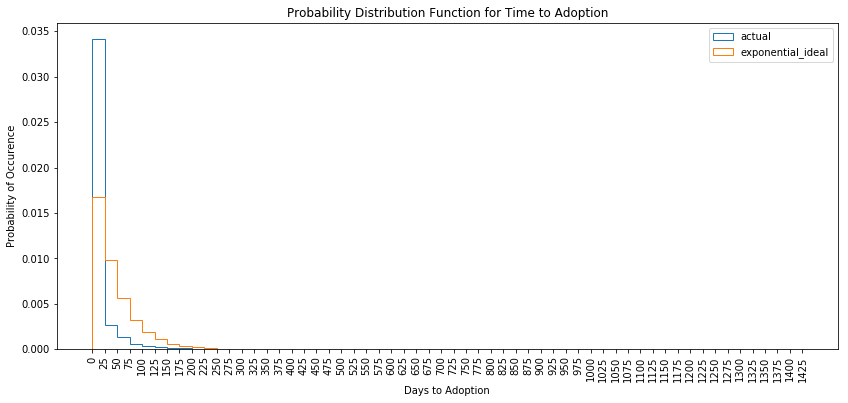

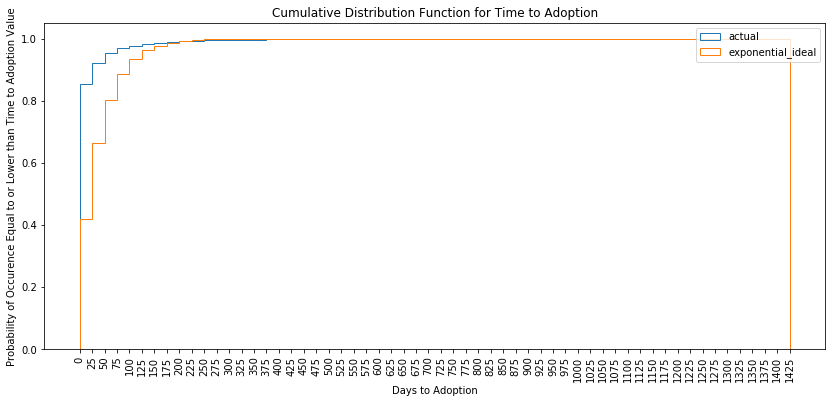

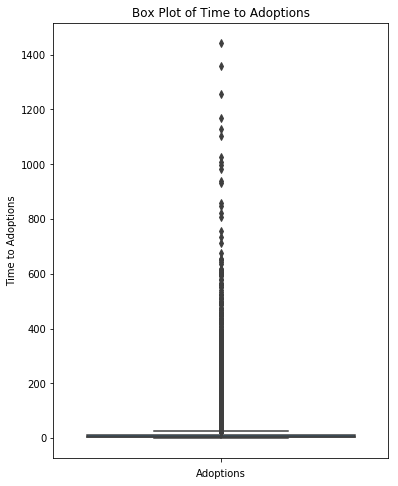

In [6]:
#c look at the distribution of time to adoption values (for adoption and return to owner values only)
time_to_adopt = dogs_join_time.loc[(dogs_join_time.outcome_type == 'Adoption') |
                                   (dogs_join_time.outcome_type == 'Return to Owner') | 
                                   (dogs_join_time.outcome_type == 'Rto-Adopt')]['shelter_time']

#set bins for histograms
bins=range(0,round(int(time_to_adopt.max())),25)

#first with a pdf
plt.figure(figsize=(14,6))
time_to_adopt.plot(kind='hist', bins=bins, normed=True, histtype='step', label='actual')
plt.xlabel('Days to Adoption')
plt.ylabel('Probability of Occurence')
plt.title('Probability Distribution Function for Time to Adoption')
plt.xticks(bins, rotation=90)

#overaly exponential distribution
std_dev = np.std(time_to_adopt)
exp_distr = np.random.exponential(scale=std_dev, size=len(dogs_join.shelter_time))
plt.hist(exp_distr, histtype='step', normed='True', bins=bins, label='exponential_ideal')
plt.legend(loc='best')
plt.show()

#second with a cdf
plt.figure(figsize=(14,6))
time_to_adopt.plot(kind='hist', bins=bins, normed=True, histtype='step', cumulative=True, label='actual')
plt.xlabel('Days to Adoption')
plt.ylabel('Probability of Occurence Equal to or Lower than Time to Adoption Value')
plt.title('Cumulative Distribution Function for Time to Adoption')
plt.xticks(bins, rotation=90)

#overlay exponential distribution
plt.hist(exp_distr, histtype='step', normed=True, cumulative=True, bins=bins, label='exponential_ideal')
plt.legend(loc='best')
plt.show()

#box plot to visualize data spread and outliers
plt.figure(figsize=(6,8))
sns.boxplot(x=time_to_adopt, orient='v')
plt.xlabel('Adoptions')
plt.ylabel('Time to Adoptions')
plt.title('Box Plot of Time to Adoptions')
plt.show()

* ### The distribution of time to adoption values seems to be exponential in nature but skewed from the ideal distribution.
* ### 95% probability that an adoption will occur in approximately 50 days or less.
    * This agrees quite well with the steady adoption rate of 30 a month.
    * Based on this I think we can break the time to adoption categories into groups for further analysis.
        * The first being adopted in 7 days (1 week) or less.
        * The second being 8 - 21 days (3 weeks).
        * The third being 22 - 50 days (7 weeks).
        * The last being 50+ days (outliers).
* ### There are outliers in the time to adoption that have taken up to 1400 days or almost 4 years to be adopted.
    * I see no evidence in the data given not to trust this as a real number.  So I will keep the outliers.
    
*****

## 2) Let's look into the intake data.
* ### Break down intakes by dog features and get basic stats.
    * a) Breeds 
        * Primary (Top 10)
        * Secondary (Top 10)
    * b) Age (Distribution)
    * c) Color
        * Primary (Top 10)
        * Secondary (Top 10)
    * d) Gender (Comparison)
    * e) Fixed (Comparison)
    * f) Intake Condition (Comparison)
    * g) Intake Type (Comparison)
    
*****

**a) Breeds**
* Primary
    * Top 10
* Secondary
    * Distribution

In [7]:
#create top 10 function
def top10(series):
    """
    Takes a series and returns the top 10 descending value counts from the series.
    """
    try: 
        sort = series.value_counts().sort_values(ascending=False)
        return(sort.head(10))
    except:
        print('Series not in dataframe.')


In [8]:
#a) Breeds.  Separate and count intakes by breeds.
top10_prim = top10(dogs_join.breed1)
print('The top 10 primary intake breeds are:\n{}'.format(top10_prim))

#now for the top secondary breeds
print()
top10_sec = top10(dogs_join.breed2)
print('The top 10 secondary intake breeds are:\n{}'.format(top10_sec))

#calculate % of total intakes that have secondary breed of Mix or none
print()
print('The % of total intakes that have secondary breed of Mix or None is {}.'.format(100*(top10_sec[0]+top10_sec[1])/
                                                                                      len(dogs_join.animal_id)))

The top 10 primary intake breeds are:
Pit Bull                 7448
Labrador Retriever       6813
Chihuahua Shorthair      6127
German Shepherd          2840
Australian Cattle Dog    1537
Dachshund                1302
Boxer                    1029
Border Collie            1006
Miniature Poodle          884
Beagle                    697
Name: breed1, dtype: int64

The top 10 secondary intake breeds are:
Mix     45609
None     3384
Name: breed2, dtype: int64

The % of total intakes that have secondary breed of Mix or None is 100.0.


* It seems that the 84% of the secondary breed data fits into 2 categories: Mix and None.
* Very few of the mixed are labeled with a second breed.
    *  More breed data would definitely help with more accurate analysis and predictions, but the how accurate is the data gathered by the shelter.  Are they conducting Dog DNA tests?  Based on just educated speculation?
    *  It's probably okay to just lump the remaining breeds that are not "None" into the Mix label.

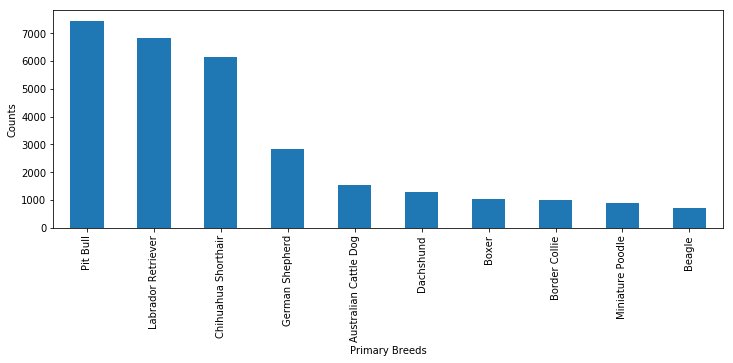

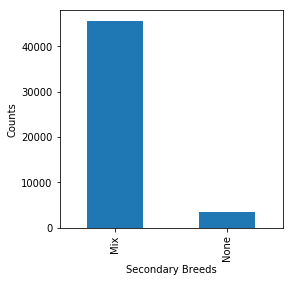

In [9]:
#lump secondary breed into Mix or None
for index, row in dogs_join.iterrows():
    if (row['breed2'] != 'Mix') & (row['breed2'] != 'None'):
        dogs_join.loc[index, 'breed2'] = 'Mix'
        
#plot top10 of each
plt.figure(figsize=(12,4))
top10_prim.plot(kind='bar')
plt.xlabel('Primary Breeds')
plt.ylabel('Counts')
plt.show()

#recalculate the cats for secondary
plt.figure(figsize=(4,4))
dogs_join.breed2.value_counts().plot(kind='bar')
plt.xlabel('Secondary Breeds')
plt.ylabel('Counts')
plt.show()

* The most popular breed taken in is pit bull which from my limited experience with dog shelters seems to be the case.
* Also, for machine learning application, I will use the complete secondary breed information.
* Does being a certain breed help in quicker or more adoptions?
    * A question for the statistical analysis section to come in a subsequent notebook.

*****

**b) Age Upon Intake**
* Distribution

Summary Statistics for Intake Age
count    48993.000000
mean        32.086573
std         36.476930
min          0.000000
25%          9.000000
50%         24.000000
75%         48.000000
max        288.000000
Name: intake_age, dtype: float64


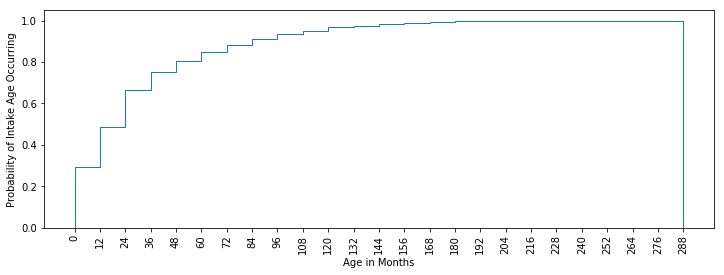

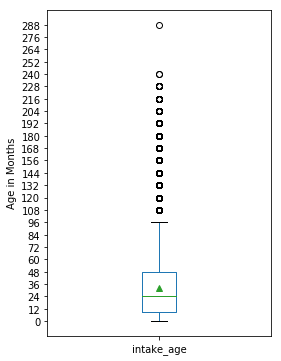

In [10]:
#get the ages and plot the distribution
#need to find min and max age etc.
ages = dogs_join.intake_age
print('Summary Statistics for Intake Age')
print(ages.describe())

#plot the distribution
#cdf
plt.figure(figsize=(12,4))
ages.plot(kind='hist', normed = True, cumulative=True, histtype='step', bins=range(0,int(ages.max())+12,12))
plt.xlabel('Age in Months')
plt.ylabel('Probability of Intake Age Occurring')
plt.xticks(range(0,int(ages.max())+12,12), rotation=90)
plt.show()

#plot boxplot
plt.figure(figsize=(4,6))
ages.plot(kind='box', showmeans=True)
plt.ylabel('Age in Months')
plt.yticks(range(0,int(ages.max())+12,12))
plt.show(0)

* 80% of the dogs that come in are 5 years old or less, which is middle age for a dog.
* There are some outliers in age of dogs out there just as there are some really old humans.  24 years old dog may be a typo but there are some at 20 which is believable, and doesn't make the 24 years seem absurd.
* Do younger dogs (puppies) get adopted sooner or more in general?
    * A question we can answer in the statistical analysis section.

****

**c) Color**
* Primary
    * Top 10
* Secondary
    * Top 10

In [11]:
#get color one and color two into series
color1 = dogs_join.color1
color2 = dogs_join.color2

#now order and get primary top 10
top_prim_color = top10(color1)
print('The top 10 primary colors are:\n{}'.format(top_prim_color))

#now for the secondary top 10
print()
top_sec_color = top10(color2)
print('The top 10 secondary colors are:\n{}'.format(top_sec_color))

The top 10 primary colors are:
Black            12601
White             8731
Brown             6234
Tan               5854
Brown Brindle     2298
Tricolor          2214
Red               2154
Blue              1878
Chocolate         1272
Sable              767
Name: color1, dtype: int64

The top 10 secondary colors are:
White            17514
None             16916
Tan               4146
Black             4119
Brown             3559
Brown Brindle      485
Tricolor           441
Gray               379
Red                304
Cream              236
Name: color2, dtype: int64


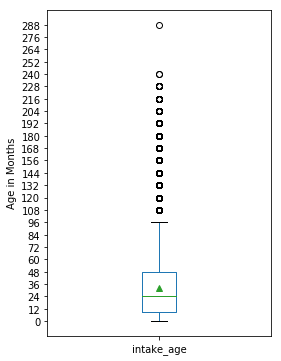

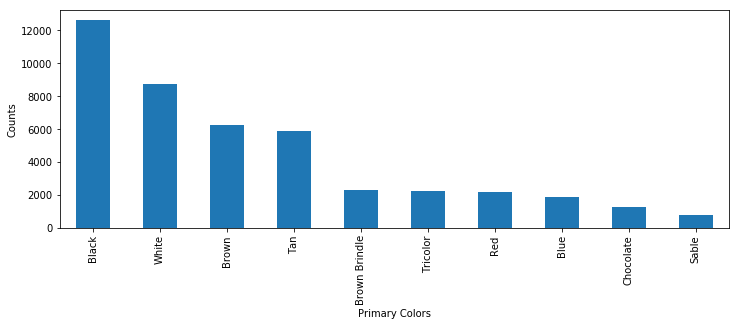

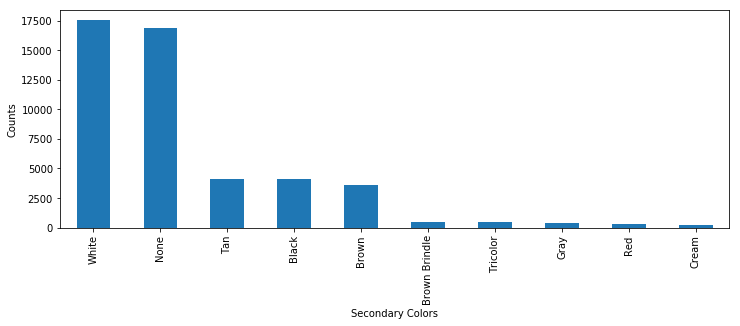

In [12]:
#plot the top 10s
#primary colors
plt.figure(figsize=(12,4))
top_prim_color.plot(kind='bar')
plt.xlabel('Primary Colors')
plt.ylabel('Counts')
plt.show()

#secondary colors
plt.figure(figsize=(12,4))
top_sec_color.plot(kind='bar')
plt.xlabel('Secondary Colors')
plt.ylabel('Counts')
plt.show()

* It looks like the top colors in general are black and white.
* The top secondary color is white or none with trace amounts of other colors.
    * Does having a secondary color make the dog more adoptable?  
        * Something to look at and answer in the statistics section.
        
*****

**d) Gender**
* Comparison

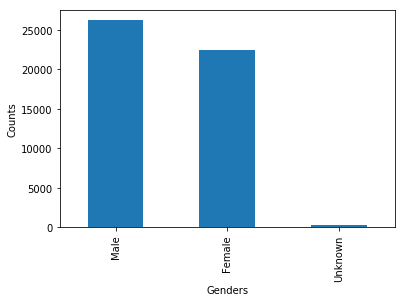

In [13]:
#separate Gender series
genders = dogs_join.intake_sex

#plot the value counts
plt.figure(figsize=(6,4))
genders.value_counts().plot(kind='bar')
plt.xlabel('Genders')
plt.ylabel('Counts')
plt.show()

* There are more intakes that are males than females but roughly 50/50.  
* There are a small amount of unknowns probably missing data.
* Does one gender get adopted more/quicker than the other?
    * A question for the statistical analysis section.
    
*****

**e)Fixed**
* Comparison

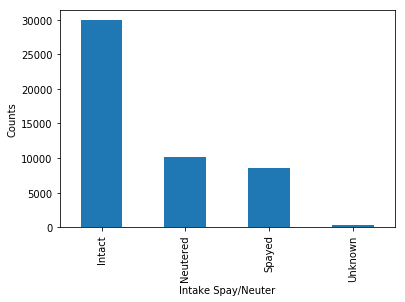

In [14]:
#isolate fixed series
fixed = dogs_join.intake_fixed

#plot the value counts
plt.figure(figsize=(6,4))
fixed.value_counts().plot(kind='bar')
plt.xlabel('Intake Spay/Neuter')
plt.ylabel('Counts')
plt.show()

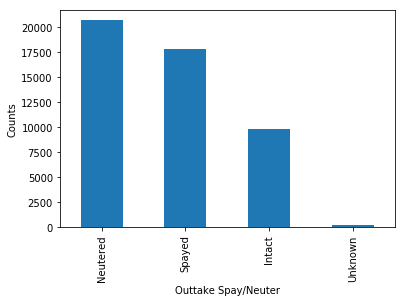

In [15]:
#let's compare this to the outtake fixed data
out_fix = dogs_join.outtake_fixed

#plot the value counts
plt.figure(figsize=(6,4))
out_fix.value_counts().plot(kind='bar')
plt.xlabel('Outtake Spay/Neuter')
plt.ylabel('Counts')
plt.show()

* It seems that the majority or roughly 2/3 of the pets in the shelter that come in intact leave spayed or neutered.  This good for population control.
* Most of the intakes are intact, while most of the outcomes are fixed.
* Does being fixed lead to being more adoptable or getting adopted quicker?
    * A question for the statistical analysis section.
* More questions that could be investigated or cross correlations between sex and fixed state and adoptability, but due to lack of time, these won't be answered presently.

*****

**f) Intake Condition**
* Comparison

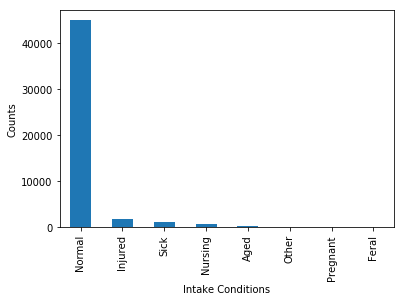

In [16]:
#get intake condition as a Series
intake_conditon = dogs_join.intake_condition

#plot the value counts
plt.figure(figsize=(6,4))
intake_conditon.value_counts().plot(kind='bar')
plt.xlabel('Intake Conditions')
plt.ylabel('Counts')
plt.show()

* The vast majority of the intakes come in in normal condition.
    * Any statistics here would be skewed by the huge weight to the Normal grouping.

*****

**g) Intake Type**
* Comparison

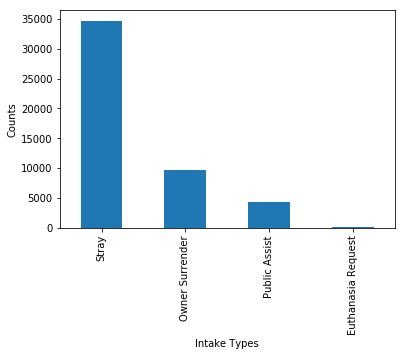


The percent of Euthanasia outcomes that were requested upon intake is 9.6.
The percent of Return to Owner outcomes that originated as Owner Surrenders is 4.2.


In [17]:
#get intake type as a Series
intake_type = dogs_join.intake_type

#plot the value counts
plt.figure(figsize=(6,4))
intake_type.value_counts().plot(kind='bar')
plt.xlabel('Intake Types')
plt.ylabel('Counts')
plt.show()

#let's calculate the percent of euthanasia outcomes that were requested
euthanasias = len(dogs_join.loc[dogs_join.outcome_type=='Euthanasia'])
euth_req = len(dogs_join.loc[(dogs_join.outcome_type=='Euthanasia') & (dogs_join.intake_type=='Euthanasia Request')])
print()
print('The percent of Euthanasia outcomes that were requested upon intake is {}.'.format(round((euth_req/euthanasias)*100,1)))

#let's calculate the percent of return to owner outcomes that were originally Owner surrender
owner_returns = len(dogs_join.loc[dogs_join.outcome_type=='Return to Owner'])
surrenders = len(dogs_join.loc[(dogs_join.outcome_type=='Return to Owner') & (dogs_join.intake_type=='Owner Surrender')])
print('The percent of Return to Owner outcomes that originated as Owner Surrenders is {}.'.format(
    round((surrenders/owner_returns)*100,1)))

* The majority of intakes are strays.
* Two interesting stats arose:
    * Most of the Euthanasia outcomes are not from requests upon intake, suggesting most of the dogs that are euthanized are not done by the owners.
    * Most owner surrenders are not returned to the owners, suggesting that one should probably not use the animal shelter as a form of free animal boarding to be on the safe side.
    
*****

## 3. Quick look at Intake Feature Correlations to Adoptions
* Let's keep with the most interesting features that aren't heavily weighted to one feature grouping.
    * Dropping intake_type and intake_condition.
* We will look at the percent adoptions multiplied by the total number of adoptions for each category grouping.
    * For example, percent of Pitbulls from intake that are adopted.
        * This will hopefully give an idea of the efficiency and quantity of the adoptions in each category grouping.
* We will also look at median time to adoption for the different category groupings.
* Following the same flow as the previous section for intake features/category groupings.
    * a) Breeds 
        * Primary (Top 10)
        * Secondary (Comparison)
    * b) Age (Distribution)
    * c) Color
        * Primary (Top 10)
        * Secondary (Top 10)
    * d) Gender (Comparison)
    * e) Fixed (Comparison)
    * f) Seasons (Comparison)
    
*****

### First we need to define functions. 
**The first to group the different features in the different time to adoption categories, which are:** 
* The first being adopted in 7 days (1 week) or less.
* The second being 8 - 21 days (3 weeks).
* The third being 22 - 50 days (7 weeks).
* The last being 50+ days (outliers).

In [18]:
#define the function 
def tta_grouper(df, tta_cat=1):
    """
    Takes a df and filters based on a desired time to adoption window.
    tta_cat values: 1 = 7 days or less, 2 = 8-21 days, 3 = 22 - 50 days, 4 = 50+ days
    """
    #define dictionary to store category details
    cats = {1: [0,7], 2: [8,21], 3: [22,50], 4: [0, np.inf]}
    
    #filter df column for the chosen category values
    df_filtered = df.loc[(df['shelter_time'] >= cats[tta_cat][0]) & (df['shelter_time'] <= cats[tta_cat][1])]
    return(df_filtered)

**Now need to make a function to calculate the percent adoptions by category grouping.**

In [19]:
def per_adopt(df, col):
    """
    Takes a dataframe, a column in the dataframe, and returns the weighted total adoption, the total adopted, and
    the percent adopted for different unique groups in the column.
    """
    #generate a pivot table from the df supplied with the col unique values as the columns and the outcome types as the index
    #and count as the aggfunc
    pivot = pd.pivot_table(df, index='outcome_type', columns=col, values='shelter_time', aggfunc='count')
    
    #now get the percent adoption of the unique values in the dataframe series chosen (count only adopted and return to owner)
    adopted = pivot.loc['Adoption',:] + pivot.loc['Return to Owner',:] + pivot.loc['Rto-Adopt']
    total_out = pivot.sum()
    
    #return the weighted total adoptions per grouping in dataframe series of interest
    return(((adopted/total_out)*(adopted)),adopted, (adopted/total_out))

**Now, we need to define the function to calculate the median time to adoption for category groupings.**

In [20]:
def median_adopt(df, col):
    """
    Takes a dataframe, a column in the dataframe, and a time to adoption category, and gives the median time to adoption for
    unique groups in the column.
    """
    #filter the dataframe to only have adoptions and return to owner as we are only concerned with time to adoptions and not 
    #time to outcome in general
    df = df.loc[(df.outcome_type=='Adoption')|(df.outcome_type=='Return to Owner')|(df.outcome_type=='Rto-Adopt')]
    
    
    #groupby the series of interest and take the median of the shelter time values
    medians = df.groupby(col).median()['shelter_time']
    
    #return the medians
    return(medians)

In [21]:
#make a function to plot the adoption information
def plot_median_per(df,col,asc):
    """
    Plots the percent adoption and median information for the category groupings.
    """
    #percent plot
    weighted, total, percent = per_adopt(df, col)
    index = weighted.sort_values(ascending=asc)[0:10].index
    per_plot = pd.concat([weighted, total, percent], axis=1)
    per_plot.columns=['Weighted Adoption Count','Total Adoptions','Percent Adoptions']

    per_plot.sort_values(by='Weighted Adoption Count', ascending=asc)[0:10].plot(kind='bar', 
                                                                         sharex=True, secondary_y=['Percent Adoptions']
                                                                             ,figsize=(12,8))
    plt.title('Weighted Adoption Totals for top ' + col)
    plt.show()
    
    #median plot for previous top10
    print()
    fig, ax = plt.subplots(2,2)
    plt.subplot(2,2,1)
    median_plot = median_adopt(dogs_join, col)
    median_plot[index].plot(kind='bar', figsize=(12,12))
    plt.ylabel('Median Days to Adoption')
    plt.title('Median Time to Adoption for Most Adopted ' + col)

    
    #median plot for lowest times to adoptions
    plt.subplot(2,2,2)
    median_plot.sort_values(ascending=not(asc))[0:10].plot(kind='bar', figsize=(12,12))
    plt.title('Median Plot for lowest times to Adoptions')
    
    #median plot for highest times to adoptions
    plt.subplot(2,2,3)
    median_plot.sort_values(ascending=asc)[0:10].plot(kind='bar', figsize=(12,12))
    plt.title('Median Plot for lowest times to Adoptions')
    fig.tight_layout()
    plt.show()
    
    #print per plot df head(10)
    print()
    print('The top adoptable data.')
    print(per_plot.sort_values('Weighted Adoption Count', ascending=asc).head(10))
    print()
    print('The lowest median time to adoption data.')
    print(per_plot.loc[median_plot.sort_values(ascending=not(asc))[0:10].index])
    print()
    print('The highest median time to adoption data.')
    print(per_plot.loc[median_plot.sort_values(ascending=asc)[0:10].index])

### Now let's get into the data.
**a) Breeds**
* Primary (Top 10)
* Secondary (Top 10)

Primary Breed

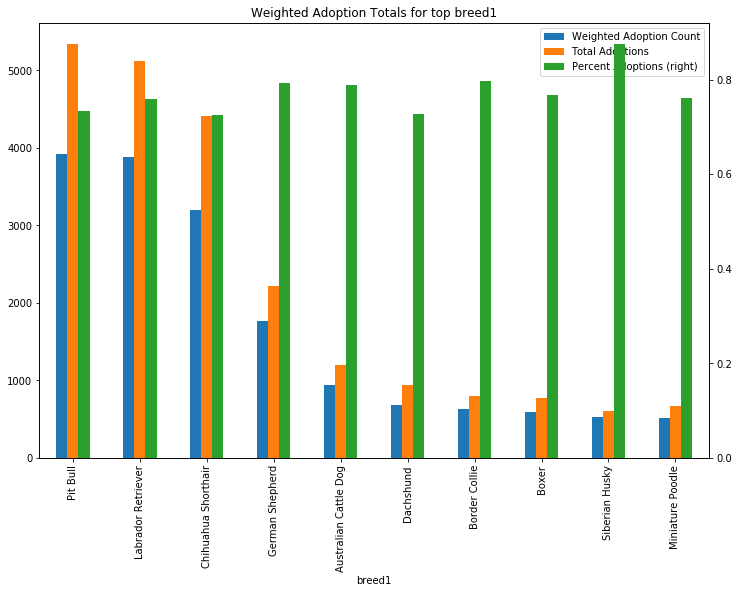

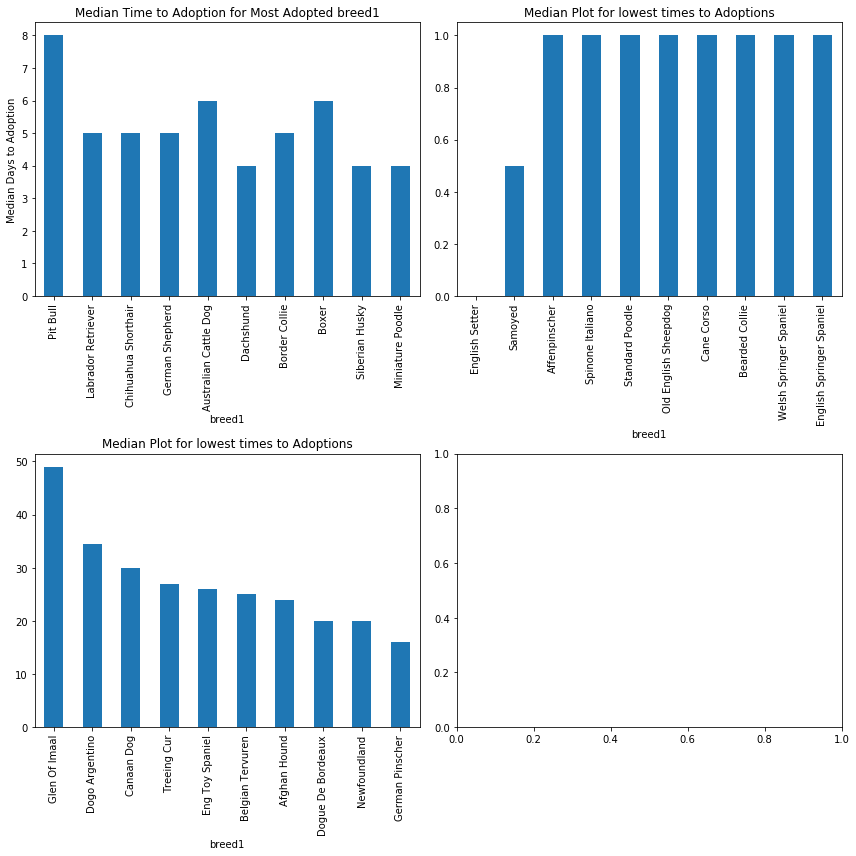


The top adoptable data.
                       Weighted Adoption Count  Total Adoptions  \
breed1                                                            
Pit Bull                           3918.787330           5346.0   
Labrador Retriever                 3885.973434           5117.0   
Chihuahua Shorthair                3196.494752           4415.0   
German Shepherd                    1761.129366           2223.0   
Australian Cattle Dog               944.213158           1198.0   
Dachshund                           685.223166            942.0   
Border Collie                       630.416080            792.0   
Boxer                               595.267592            775.0   
Siberian Husky                      531.672439            607.0   
Miniature Poodle                    511.420159            672.0   

                       Percent Adoptions  
breed1                                    
Pit Bull                        0.733032  
Labrador Retriever              0.759424 

In [22]:
#plot data for the primary breed information
plot_median_per(dogs_join,'breed1', False)

Secondary Breed

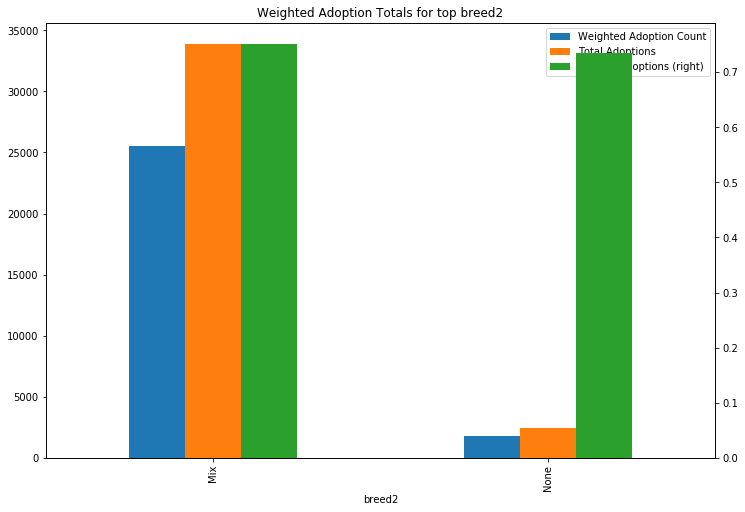

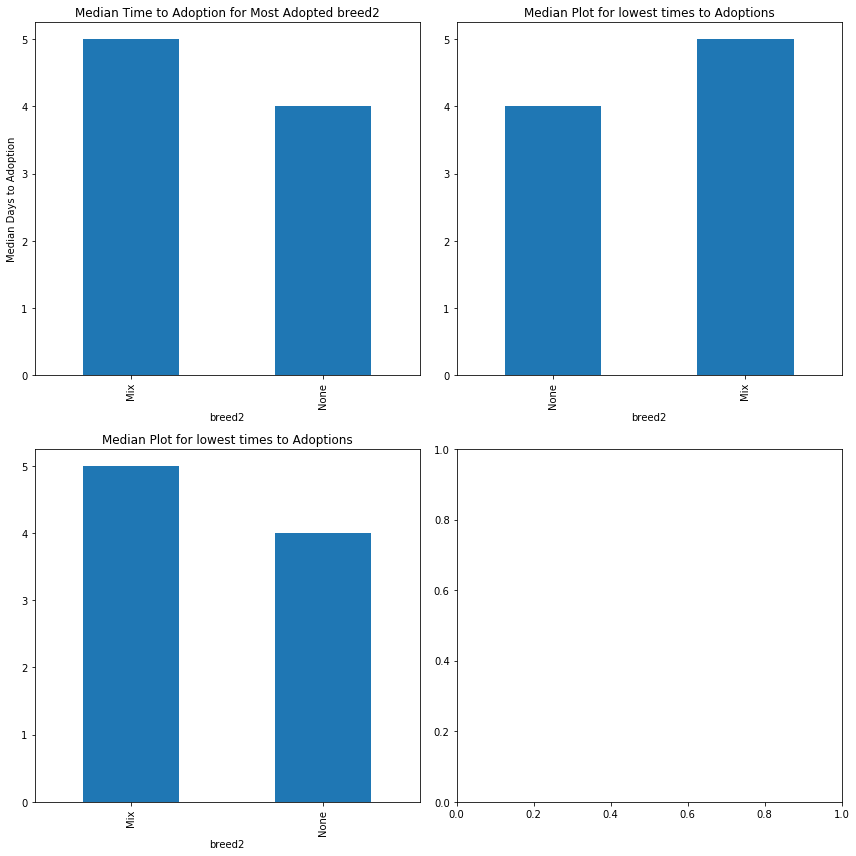


The top adoptable data.
        Weighted Adoption Count  Total Adoptions  Percent Adoptions
breed2                                                             
Mix                25491.888357          33910.0           0.751751
None                1816.373329           2473.0           0.734482

The lowest median time to adoption data.
        Weighted Adoption Count  Total Adoptions  Percent Adoptions
breed2                                                             
None                1816.373329           2473.0           0.734482
Mix                25491.888357          33910.0           0.751751

The highest median time to adoption data.
        Weighted Adoption Count  Total Adoptions  Percent Adoptions
breed2                                                             
Mix                25491.888357          33910.0           0.751751
None                1816.373329           2473.0           0.734482


In [23]:
plot_median_per(dogs_join, 'breed2', False)

* It seems that the most popular adopted primary breeds are Labradors and Pitbulls, but these are also the most numerous primary breeds for intakes as well.
    * There efficiency isn't too bad either, with about 72% of the pitbulls leaving the shelter under favorable means.
        * About 75% for the labradors.
        * All the dogs in the top 10 weighted adoption count are above 70% adoptions.


* Moreover, the more exotic are lesser seen breeds are usually adopted quicker as shown in the lowest median time to adoption plot.
    * All the breeds in there are "exotic", i.e., not pitbull, labs, german shephards, daschund, chihuahua, etc..
    * However, the longest median time to adoption breeds are also exotics, these are both outlier groups with low numbers of total adoption.  There may be other factors at play such as age, sex, etc.
    

* The median time to adoption shows that it takes a bit longer for the pitbulls to be adopted at a median time to adoption of 8 days.  
    * This still isn't too bad and the time to adoption for the top adopted breeds are all under 10 days median time to adoption.
    

* The secondary breed information suggests that mixed vs. pure breed doesn't really play an impact on the adoptions or median time to adoption.
    * Although there are substantially more mixed breed dogs in the shelter than pure breeds, which makes since if the majority of the intake type are strays, roaming free to breed with whomever, whenever.
    
*****

**b) Age**
* Break age into groupings:
    * Puppy (0-12 Months Old)
    * Young Adult (13-36 Months Old)
    * Adult (37-72 Months Old)
    * Senior (73+ Months Old)

In [24]:
#Define a dictionary to store the age ranges
dog_ages = {'Puppy':[0,12], 'Young Adult':[13,36], 'Adult':[37,72], 'Senior':[73,np.inf]}

#now add the intake_age_cat column to dogs_join
for key, value in dog_ages.items():
    for index, row in dogs_join.iterrows():
        if value[0] <= row['intake_age'] <= value[1]:
            dogs_join.loc[index,'intake_age_cat'] = key

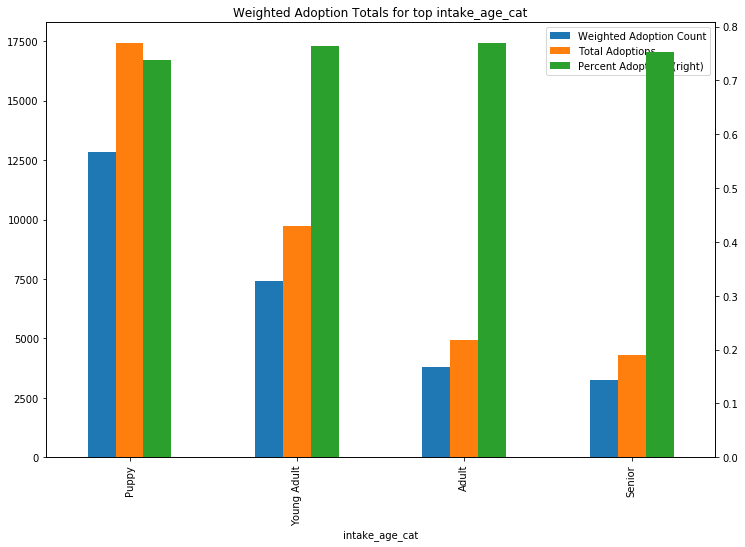

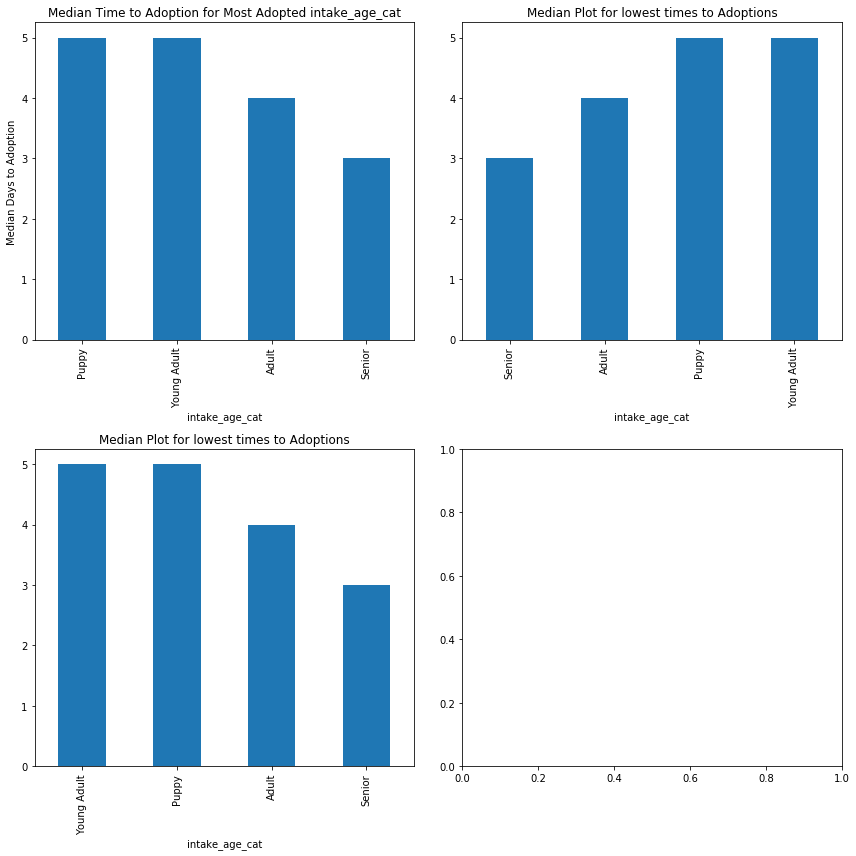


The top adoptable data.
                Weighted Adoption Count  Total Adoptions  Percent Adoptions
intake_age_cat                                                             
Puppy                      12853.964758          17420.0           0.737885
Young Adult                 7432.154305           9736.0           0.763368
Adult                       3788.402500           4924.0           0.769375
Senior                      3240.995799           4303.0           0.753194

The lowest median time to adoption data.
                Weighted Adoption Count  Total Adoptions  Percent Adoptions
intake_age_cat                                                             
Senior                      3240.995799           4303.0           0.753194
Adult                       3788.402500           4924.0           0.769375
Puppy                      12853.964758          17420.0           0.737885
Young Adult                 7432.154305           9736.0           0.763368

The highest median t

In [25]:
#now look into plots for the Age Groups
plot_median_per(dogs_join, 'intake_age_cat', False)

* There seems to be an equal efficiency in adoptions between ages.
* Also there appears to be a negative correlation between intake age and time to adoption.

*****

**c) Color**
* Primary(Top 10)
* Secondary(Top 10)

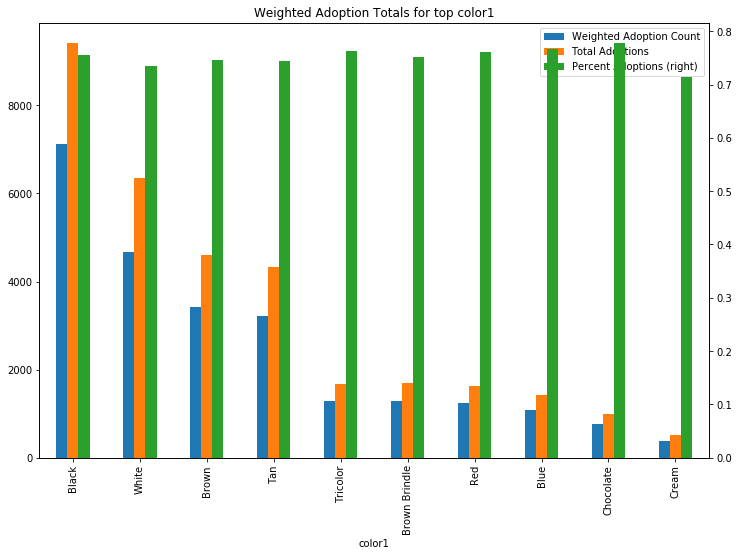

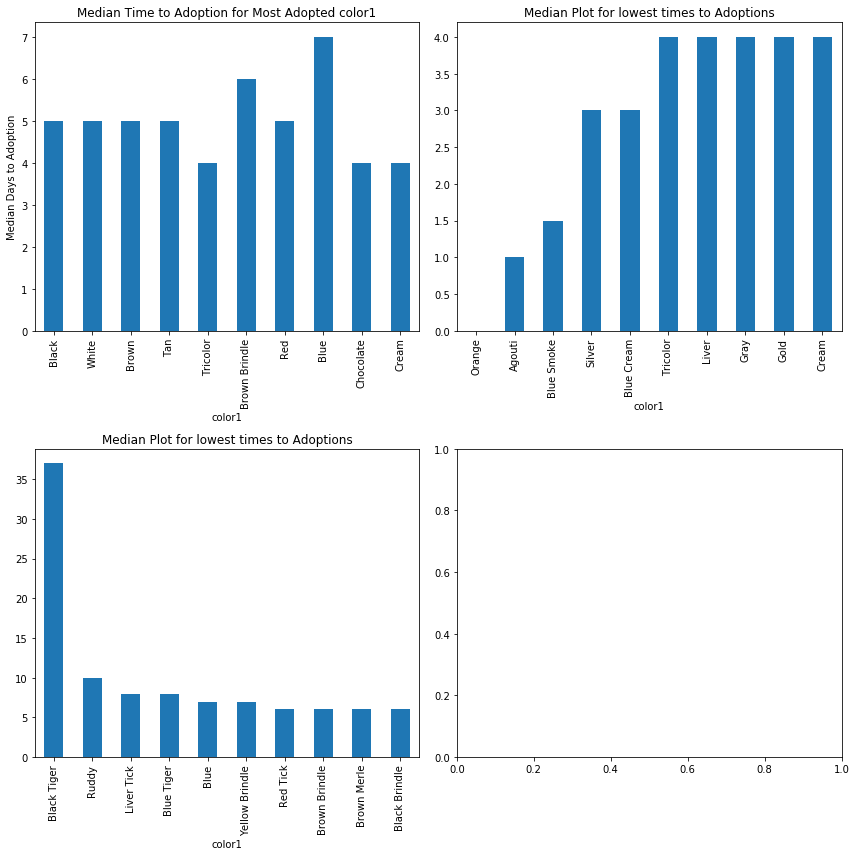


The top adoptable data.
               Weighted Adoption Count  Total Adoptions  Percent Adoptions
color1                                                                    
Black                      7116.095211           9411.0           0.756147
White                      4669.506946           6351.0           0.735240
Brown                      3428.359669           4597.0           0.745782
Tan                        3217.830085           4319.0           0.745041
Tricolor                   1284.214253           1682.0           0.763504
Brown Brindle              1279.699690           1701.0           0.752322
Red                        1240.235845           1628.0           0.761816
Blue                       1083.913681           1413.0           0.767101
Chocolate                   763.518606            982.0           0.777514
Cream                       369.183702            517.0           0.714088

The lowest median time to adoption data.
            Weighted Adoption Cou

In [26]:
#get the data for Primary
plot_median_per(dogs_join, 'color1', False)

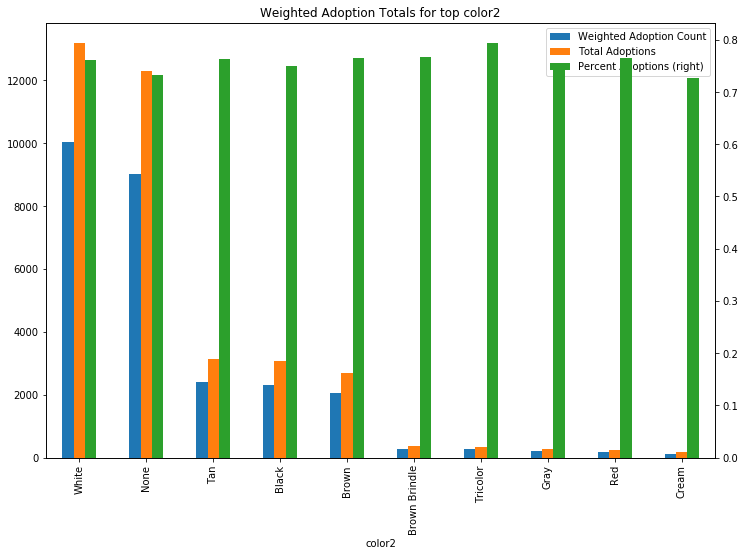

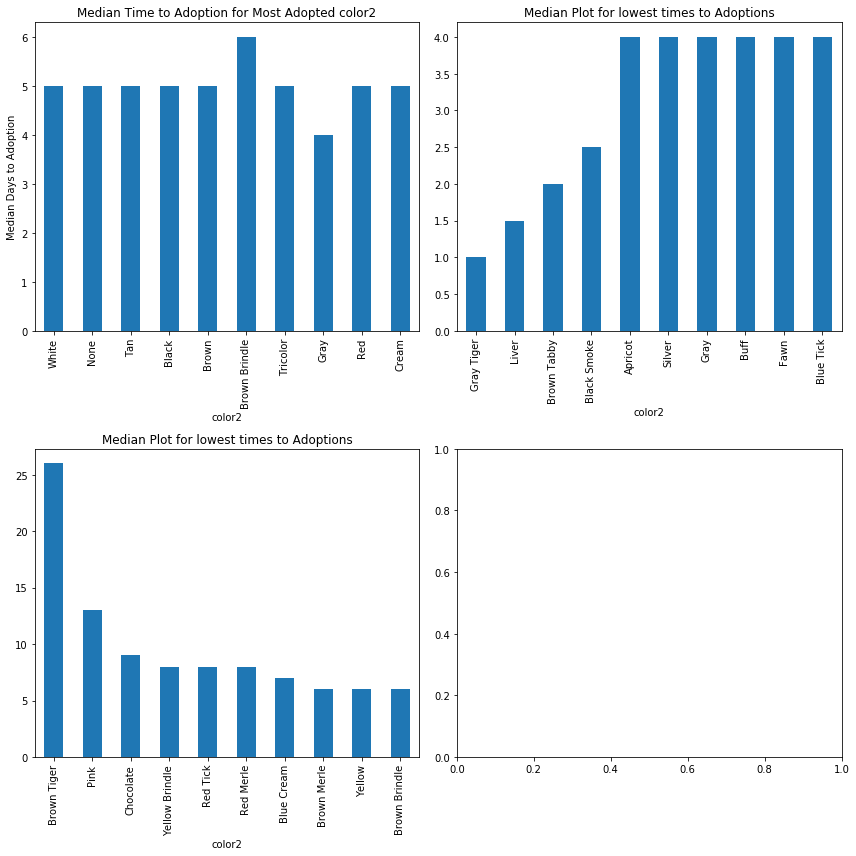


The top adoptable data.
               Weighted Adoption Count  Total Adoptions  Percent Adoptions
color2                                                                    
White                     10038.059177          13173.0           0.762018
None                       9002.988960          12283.0           0.732963
Tan                        2404.372178           3147.0           0.764020
Black                      2299.502206           3063.0           0.750735
Brown                      2059.579352           2691.0           0.765358
Brown Brindle               281.187891            367.0           0.766180
Tricolor                    276.820455            349.0           0.793182
Gray                        213.941645            284.0           0.753316
Red                         176.692053            231.0           0.764901
Cream                       123.504274            170.0           0.726496

The lowest median time to adoption data.
             Weighted Adoption Co

In [27]:
#Now for the Secondary color
plot_median_per(dogs_join, 'color2', False)

* It seems that neither primary color or secondary color have a big impact on adoptions or time to adoptions shown by the fact that most colors have a median time to adoption of around 5 days.
    * Also, the percent adoptions all similar.
    
*****

**d) Gender**
* Comparison

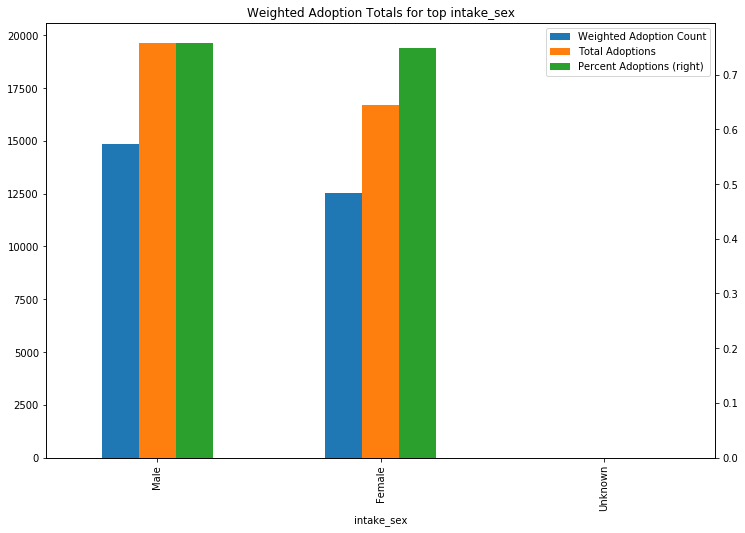

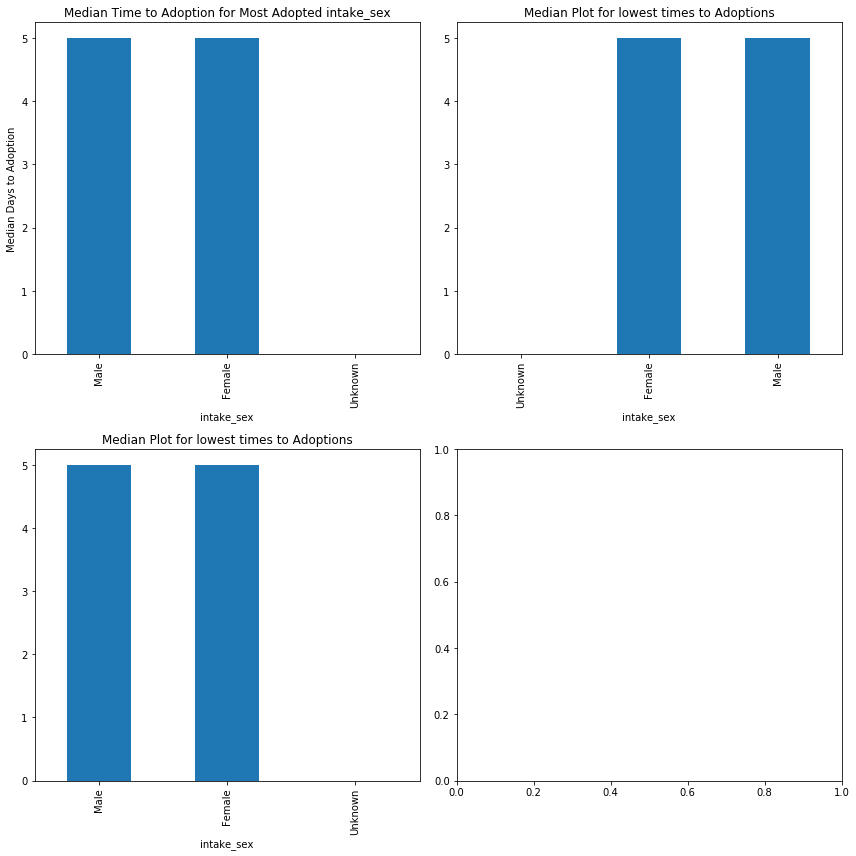


The top adoptable data.
            Weighted Adoption Count  Total Adoptions  Percent Adoptions
intake_sex                                                             
Male                   14856.408475          19620.0           0.757207
Female                 12526.132006          16714.0           0.749440
Unknown                         NaN              NaN                NaN

The lowest median time to adoption data.
            Weighted Adoption Count  Total Adoptions  Percent Adoptions
intake_sex                                                             
Unknown                         NaN              NaN                NaN
Female                 12526.132006          16714.0           0.749440
Male                   14856.408475          19620.0           0.757207

The highest median time to adoption data.
            Weighted Adoption Count  Total Adoptions  Percent Adoptions
intake_sex                                                             
Male                   148

In [28]:
#plot the plots!
plot_median_per(dogs_join, 'intake_sex', False)

* The gender doesn't seem to have an appreciable impact either based on the exact same results for both males and females.

*****

**e) Fixed**
* Comparison

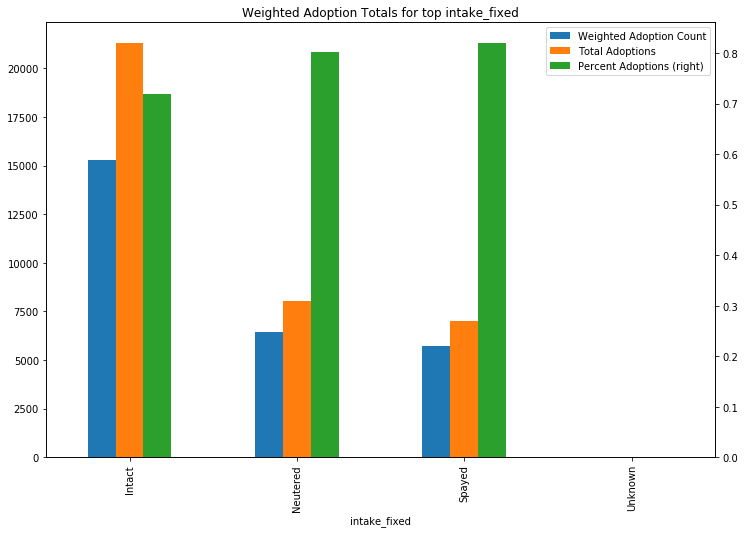

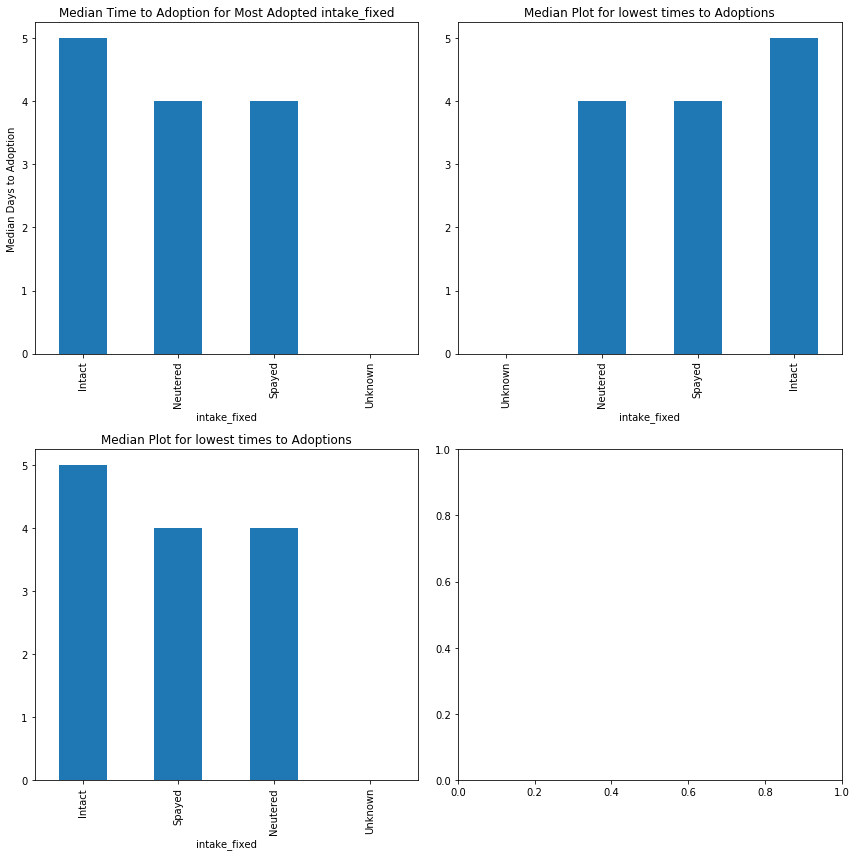


The top adoptable data.
              Weighted Adoption Count  Total Adoptions  Percent Adoptions
intake_fixed                                                             
Intact                   15295.549096          21298.0           0.718168
Neutered                  6444.848328           8034.0           0.802197
Spayed                    5739.639897           7002.0           0.819714
Unknown                           NaN              NaN                NaN

The lowest median time to adoption data.
              Weighted Adoption Count  Total Adoptions  Percent Adoptions
intake_fixed                                                             
Unknown                           NaN              NaN                NaN
Neutered                  6444.848328           8034.0           0.802197
Spayed                    5739.639897           7002.0           0.819714
Intact                   15295.549096          21298.0           0.718168

The highest median time to adoption data.
  

In [29]:
#plot the plots!
plot_median_per(dogs_join, 'intake_fixed', False)

* It seems there may be a slight favor for the fixed dogs to get adopted faster and more often then the intact intakes.
    * The median time to adoption is shorter for fixed dogs.
    * The percent adopted is slightly higher for the fixed dogs.


* This apparent time reduction to adoption could be from the fact that the recorded adopted factors in surgery time as most dogs leave the shelter fixed even when they came in intact.

*****

**f) Seasons**
* Comparison

In [30]:
#need to break the intake dates into seasons.
#create a seasons dictionary
seasons = {'Winter':[12,1,2], 
          'Spring':[3,4,5],
          'Summer':[6,7,8],
          'Fall':[9,10,11]}

#change datetime_in to datetime datatype
dogs_join.datetime_in = pd.to_datetime(dogs_join.datetime_in)

#now label each dataframe entry with a season in the season column
for index, row in dogs_join.iterrows():
    for key, value in seasons.items():
        if row['datetime_in'].month in value:
            dogs_join.loc[index, 'intake_season'] = key


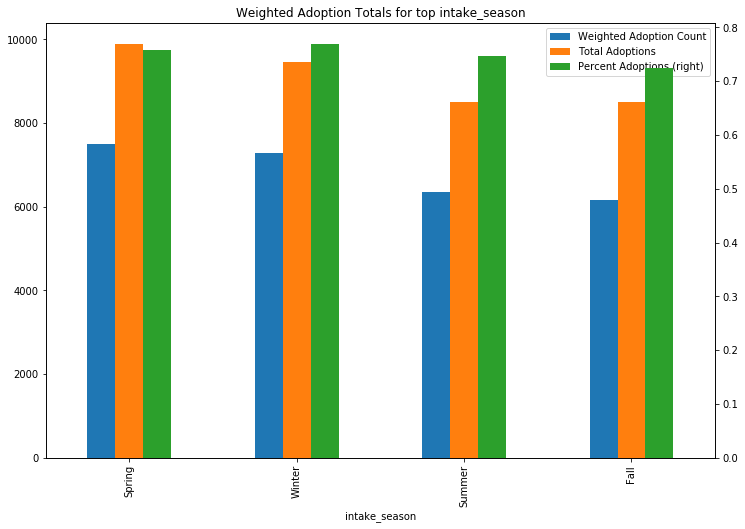

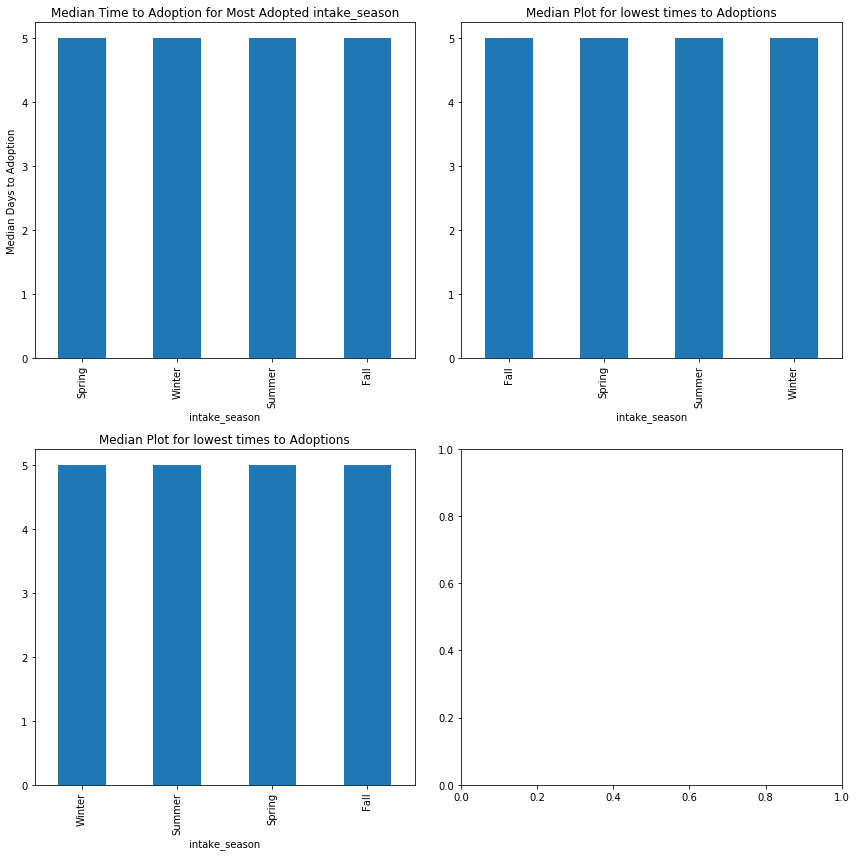


The top adoptable data.
               Weighted Adoption Count  Total Adoptions  Percent Adoptions
intake_season                                                             
Spring                     7505.951819           9899.0           0.758254
Winter                     7281.422029           9461.0           0.769625
Summer                     6360.648231           8512.0           0.747257
Fall                       6172.215491           8511.0           0.725204

The lowest median time to adoption data.
               Weighted Adoption Count  Total Adoptions  Percent Adoptions
intake_season                                                             
Fall                       6172.215491           8511.0           0.725204
Spring                     7505.951819           9899.0           0.758254
Summer                     6360.648231           8512.0           0.747257
Winter                     7281.422029           9461.0           0.769625

The highest median time to adopt

In [31]:
#now plot the season adoption data
plot_median_per(dogs_join, 'intake_season', False)

* As shown in the time series plot at the beginning the time of year doesn't really seem to have an effect on the adoptions.

*****

## 4. Look into Outcome Types Correlations to Intake Features
* Break the outcome types into Main Groups.
    * Adoptions (Adoptions, Return to Owner, Rto-Adopt)
    * Transfers (Transfer)
    * Deaths (Died, Euthanasia, Disposal, Missing, Unknown)
    

* Look at the following intake features:
    * a) Breeds 
        * Primary (Top 10)
    * b) Gender (Comparison)

In [32]:
#filter data frames into the main groups
dog_adoptions = dogs_join.loc[(dogs_join.outcome_type == 'Adoption') | (dogs_join.outcome_type == 'Return to Owner')
                             | (dogs_join.outcome_type == 'Rto-Adopt')]
dog_transfers = dogs_join.loc[dogs_join.outcome_type == 'Transfer']
dog_deaths = dogs_join.loc[(dogs_join.outcome_type == 'Died') | (dogs_join.outcome_type == 'Euthanasia') | 
                           (dogs_join.outcome_type == 'Disposal') | (dogs_join.outcome_type == 'Missing') | 
                           (dogs_join.outcome_type == 'Unknown')]

**a) Breeds**
* Primary (Top 10)

In [33]:
#get the top10 
print('The top 10 adoptions breeds')
print(top10(dog_adoptions.breed1))
print()
print('The top 10 transfers breeds')
print(top10(dog_transfers.breed1))
print()
print('The top 10 deaths breeds')
print(top10(dog_deaths.breed1))

The top 10 adoptions breeds
Pit Bull                 5346
Labrador Retriever       5117
Chihuahua Shorthair      4415
German Shepherd          2223
Australian Cattle Dog    1198
Dachshund                 942
Border Collie             792
Boxer                     775
Miniature Poodle          672
Siberian Husky            607
Name: breed1, dtype: int64

The top 10 transfers breeds
Chihuahua Shorthair      1480
Pit Bull                 1438
Labrador Retriever       1436
German Shepherd           496
Dachshund                 320
Australian Cattle Dog     282
Shih Tzu                  259
Boxer                     188
Miniature Poodle          184
Border Collie             177
Name: breed1, dtype: int64

The top 10 deaths breeds
Pit Bull                 509
Chihuahua Shorthair      203
Labrador Retriever       185
German Shepherd           87
Boxer                     46
Australian Cattle Dog     40
Rottweiler                36
Dachshund                 33
Chow Chow                 29
Mi

* It seems that there are a lot of the top breeds in all outcome types.
* The only ones that stand out are Shih Tzus get transfered a lot to other shelters or organizations.
    * Also, Chow Chow are on the top 10 deaths list.
    * There also aren't a lot of deaths in the shelter which is good.
    
*****

**b) Gender**
* Comparison

In [34]:
#get the comparisons
print('The gender adoptions gender comparison')
print(top10(dog_adoptions.intake_sex))
print()
print('The transfers gender comparison')
print(top10(dog_transfers.intake_sex))
print()
print('The deaths gender comparison')
print(top10(dog_deaths.intake_sex))

The gender adoptions gender comparison
Male       19620
Female     16714
Unknown       49
Name: intake_sex, dtype: int64

The transfers gender comparison
Male       5332
Female     4885
Unknown     169
Name: intake_sex, dtype: int64

The deaths gender comparison
Male       959
Female     703
Unknown     44
Name: intake_sex, dtype: int64


* The gender seems to be relatively evenly split in all outcome types.

*****

## 5. Special Case Study Return Visits
* Look into the return visit cases income and outcome types.

The total intake type counts for comparison


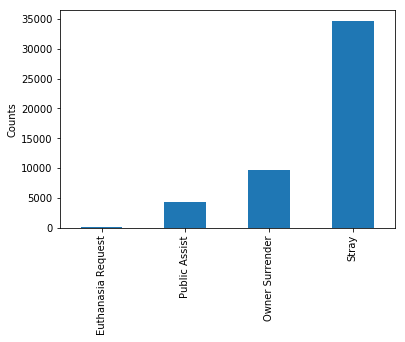


The intake type for return visits


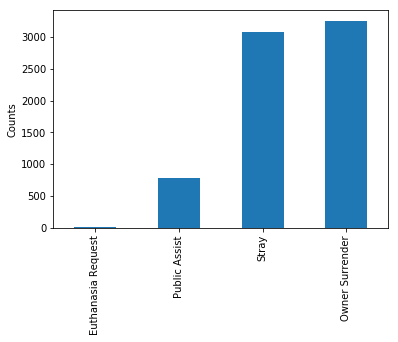


The total outcome type counts for comparison


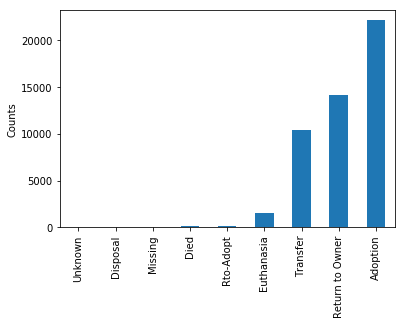


The outcome type for return visits


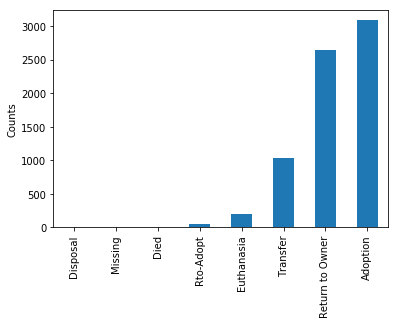

In [35]:
#get return visits by filtering on intake > 1 in dogs_join
return_visits = dogs_join.loc[dogs_join.intake > 1]

#now plot the value counts for the outcome types and intake types
print('The total intake type counts for comparison')
dogs_join.intake_type.value_counts().sort_values().plot(kind='bar')
plt.ylabel('Counts')
plt.show()
print()

print('The intake type for return visits')
return_visits.intake_type.value_counts().sort_values().plot(kind='bar')
plt.ylabel('Counts')
plt.show()
print()

print('The total outcome type counts for comparison')
dogs_join.outcome_type.value_counts().sort_values().plot(kind='bar')
plt.ylabel('Counts')
plt.show()
print()

print('The outcome type for return visits')
return_visits.outcome_type.value_counts().sort_values().plot(kind='bar')
plt.ylabel('Counts')
plt.show()

* It seems that a fair amount of return visits are due to owners giving there pets up and trying to reclaim them.  
    * Maybe trying to utilize the shelter as "free boarding", but as shown earlier a low percentage of owner surrenders end up back as owner surrenders.  A risk worth taking?
    * Also, this would eat up a lot of valuable shelter resources and potentially cause lots of unnecessary heartbreak.
    
*****

## 6. A little Time Series Analysis
* Going to look at the trends of Adoptions over time for the Top 5 breeds Identified earlier.
    * Pit Bull                          
    * Labrador Retriever                
    * Chihuahua Shorthair             
    * German Shepherd                    
    * Australian Cattle Dog
* Breeds seem to be the most interesting statistically to look by first inspection.

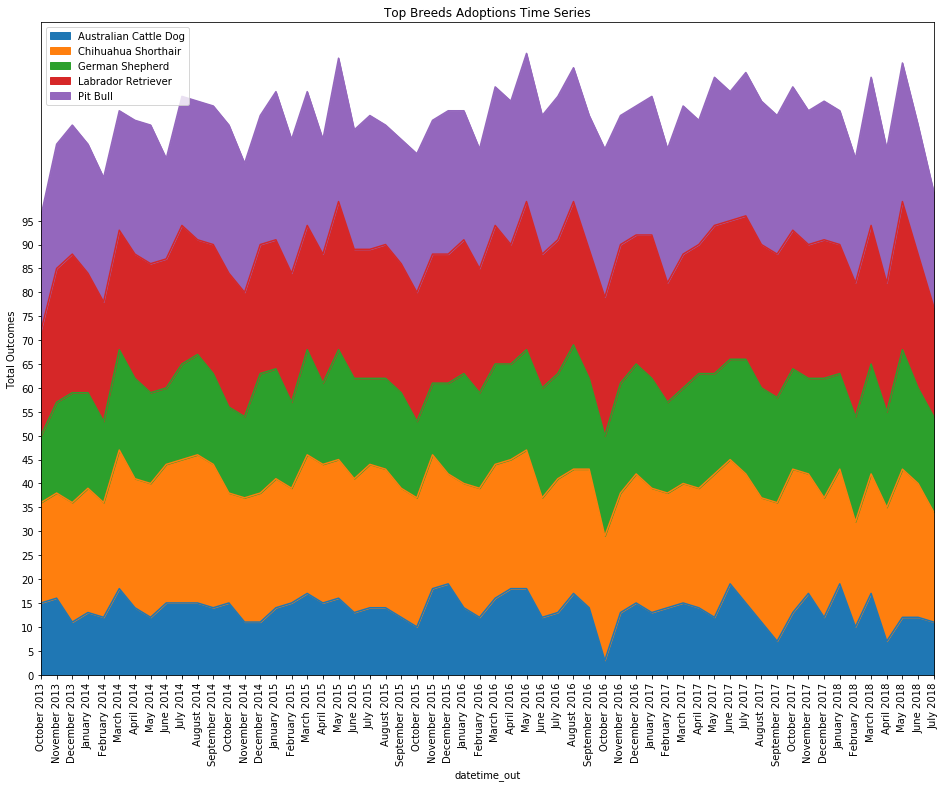

In [36]:
#Now we need to take the adoptions dataframe and set the datetime_in as the index
adoption_by_time = dog_adoptions.set_index('datetime_out',drop=True)
adoption_by_time.index = pd.to_datetime(adoption_by_time.index)
adoption_by_time.sort_index()

#select out only the breeds above
adoption_by_time_top_breeds = adoption_by_time.loc[(adoption_by_time.breed1 == 'Pit Bull') |  
                                                  (adoption_by_time.breed1 == 'Labrador Retriever') | 
                                                  (adoption_by_time.breed1 == 'Chihuahua Shorthair') | 
                                                  (adoption_by_time.breed1 == 'German Shepherd') | 
                                                  (adoption_by_time.breed1 == 'Australian Cattle Dog')]

#now pivot with index as the datetime_in and the breeds as the columns
pivot_time = pd.pivot_table(adoption_by_time_top_breeds, index=adoption_by_time_top_breeds.index, 
                            columns='breed1', values='color1', aggfunc='count')

#resample monthly
pivot_time = pivot_time.resample('M').count()

#plot pivot_time
pivot_time.plot(kind='area', stacked=True, figsize=(16,12))
x_labels = [date.strftime('%B %Y') for date in pivot_time.index]
plt.title('Top Breeds Adoptions Time Series')
plt.ylabel('Total Outcomes')
plt.yticks(range(0, 100, 5))
plt.xticks(x_labels, x_labels, rotation=90)
plt.legend(loc='best')
plt.show()
plt.show()

* Interestingly it looks like they may run adoption events or something in the fall and spring.  A lot of the peaks seem cyclical and line up well with fall and spring months.
    * Or this could just be people feel like adopting more before and after winter.
    
* More in depth looks could be done into time series analysis, but this is good for now.
    
*****

# Next step is to do some statistical testing.

In [37]:
import json
#save some of the dataframes generated in this notebook
dogs_join.to_csv('C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dogs_join.csv', index=False)
dog_adoptions.to_csv('C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dogs_adoptions.csv', index=False)
dog_transfers.to_csv('C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dogs_transfers.csv', index=False)
dog_deaths.to_csv('C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dogs_deaths.csv', index=False)
return_visits.to_csv('C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/return_visits.csv', index=False)

#save some of the dictionaries as json
with open('C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dog_ages.json', 'w') as fp:
    json.dump(dog_ages, fp)
with open('C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/seasons.json','w') as fp:
    json.dump(seasons, fp)